In [1]:

import os
import torch
from d2l import torch as d2l
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
import json

import con_function


###########################################
############### mass_spectra ##############
###########################################
# 读取所有的mass_spectra
with open('data/mass_spectra.json') as f_ms:
    mass_spectras = json.load(f_ms)
# mass_spectra分割
new_mass_spectras = [list(map(float, mass_spectra.split())) for mass_spectra in mass_spectras]
length_new_mass_spectras = [len(list(map(float, mass_spectra.split()))) for mass_spectra in mass_spectras]

print(f"max_length_mass_spectras: {max(length_new_mass_spectras)}")
# corpus: 索引号     vocab：所有元素
src_corpus, src_vocab = con_function.load_corpus_ms(new_mass_spectras, max_tokens=-1)
# 特殊符号
print(src_vocab['<unk>'], src_vocab['<pad>'], src_vocab['<bos>'], src_vocab['<eos>'])
# mass_spectras添加特殊符号
new_mass_spectras_tokens = con_function.new_lines_ms(new_mass_spectras)
# 填充mass_spectra

numpy_mass_spectra = [con_function.truncate_pad(src_vocab[token], max(length_new_mass_spectras), src_vocab['<pad>']) for token in new_mass_spectras_tokens]
print(len(numpy_mass_spectra), len(new_mass_spectras_tokens))
new_mass_spectras_tokens = list(new_mass_spectras_tokens) 
for i in np.arange(len(new_mass_spectras_tokens)):
    for j in np.arange(len(new_mass_spectras_tokens[i])):
        numpy_mass_spectra[i][j] = new_mass_spectras_tokens[i][j]
# print(numpy_mass_spectra.shape)

numpy_mass_spectra = numpy_mass_spectra[:][:100]
tensor_mass_spectra = torch.tensor(numpy_mass_spectra)

print(len(tensor_mass_spectra[0]))

# tensor_mass_spectra = torch.tensor([con_function.truncate_pad(src_vocab[token], 100, src_vocab['<pad>']) for token in new_mass_spectras_tokens])
# print(f"tensor_mass_spectra[0]: \n\t{tensor_mass_spectra[0]}")


#############################################
################### smiles ##################
#############################################
# 读取所有的smiles
smiles = con_function.read_smiles()
# corpus: 索引号     vocab：所有元素
tgt_corpus, tgt_vocab = con_function.load_corpus_smiles(smiles, max_tokens=-1)
# smiles添加特殊符号
smiles_tokens = con_function.new_lines(smiles)
# 填充smiles
tensor_smiles = torch.tensor([con_function.truncate_pad(tgt_vocab[token], 200, tgt_vocab['<pad>']) for token in smiles_tokens])
print(f'tensor_smiles[0]:  \n\t{tensor_smiles[0]}')

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
src_num_steps, tgt_num_steps = 100, 200
batch_size, lr, num_epochs, device = 64, 0.001, 200, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = con_function.load_data_nmt(
    batch_size=batch_size, source=new_mass_spectras, target=smiles, 
    src_num_steps=src_num_steps, tgt_num_steps=tgt_num_steps)
# train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=16, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    # print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    # print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break


max_length_mass_spectras: 116
0 0 0 0
4253 4253
116
tensor_smiles[0]:  
	tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
X的有效长度: tensor([ 4, 12,  6, 32,  8,  4,  6,  6,  6, 28, 10, 16,  8, 36,  2,  2,  4,  4,
         8, 22, 24,  8,  8,  8,  6, 20,  4,  8, 26,  4,  6, 12,  6,  6,  2, 28,
         4, 18, 12,  4, 28,  2, 22,  6,  4, 24,  6, 14, 12,  4,  4, 10,  8, 18,
      

epoch: 199: loss 0.001, 106358.1 tokens/sec on cuda:4


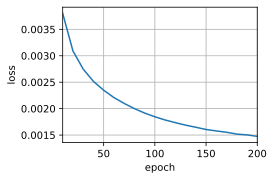

In [2]:

import seq_to_seq
from seq_to_seq import Seq2SeqEncoder, Seq2SeqDecoder, train_seq2seq
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

os.environ['CUDA_VISIBLE_DEVICES'] = "4, 5, 6, 7"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu") 
# device = torch.device(['/gpu:4', '/gpu:5'] if torch.cuda.is_available() else "cpu") 


train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab,  device)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "4, 5, 6, 7"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu") 
src_test = new_mass_spectras[int(len(tensor_mass_spectra)*0.8):]
tgt_test = smiles[int(len(tensor_smiles)*0.8):]
for src, tgt in zip(src_test, tgt_test):
    translation, attention_weight_seq = seq_to_seq.predict_seq2seq(net, src, src_vocab, tgt_vocab, src_num_steps, tgt_num_steps, device)
    print(f'{src} => {translation}, bleu {seq_to_seq.bleu(translation, tgt, k=2):.3f}')

tensor([[2]], device='cuda:4')
pred_seq: <bos> O C [ C @@ ] ( ( C [ C @@ ] 3 ( C O ) C C ( O ) C C C C C C C C ( O ) C ( O ) C O ) C C C C ( C ) ) O C C C C C 3 O C 3 C C C C 2 ) C C C 3 O C 3 C C C ( C O ) C C 3 3 ) C ) C C C C 2 ) C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C, 
label_seq: CN1CC(=O)NC1=N
[285.0, 100.0, 255.0, 100.0, 227.0, 100.0] => <bos> O C [ C @@ ] ( ( C [ C @@ ] 3 ( C O ) C C ( O ) C C C C C C C C ( O ) C ( O ) C O ) C C C C ( C ) ) O C C C C C 3 O C 3 C C C C 2 ) C C C 3 O C 3 C C C ( C O ) C C 3 3 ) C ) C C C C 2 ) C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C C, bleu 0.066
tensor([[2]], device='cuda:4')
pred_seq: <bos> O C [ C @@ ] (